# 02 analysis & placebos
This notebook explores  our baseline and robustness for the Double ML results, including alternative machine learning models and subsampling by region or income group.


In [2]:
import sys
import subprocess

def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages (module name, pip name if different)
required_packages = [
    ("statsmodels", "statsmodels"),
    ("xgboost", "xgboost"),
    ("sklearn", "scikit-learn"),
    ("scipy", "scipy"),
    ("pandas", "pandas"),
    ("numpy", "numpy"),
]

for module_name, pip_name in required_packages:
    install_if_missing(module_name)


In [3]:
"""
This script performs a comprehensive causal machine‑learning analysis of the
relationship between lagged climate vulnerability and sovereign bond spreads.
It includes:

1.  Data preparation (loading, renaming columns, computing lags and dummy
    variables).
2.  Baseline Double Machine Learning (DML) with leave‑one‑year‑out cross‑fitting
    for a binary “high‑spread” event (top 10 % of spreads).
3.  Robustness checks: random permutation placebo, heterogeneity by income and
    governance quality, regional splits.
4.  First‑difference DML to remove time‑invariant fixed effects.
5.  Instrumental‑variable (2SLS) regression using the second lag of
    vulnerability as an instrument.
6.  Linear quantile regressions at the 90th, 95th and 99th percentiles.
7.  Quantile gradient boosting regressions at the 95th and 99th percentiles and
    estimation of the marginal effect of vulnerability on these conditional
    quantiles.

The code is designed to be run in a notebook or standalone Python script.  It
prints out key results for inclusion in an academic paper.
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import norm, t


def load_and_prepare_data(csv_path: str) -> pd.DataFrame:
    """Load the dataset, rename columns to avoid spaces, compute lags and dummy vars.

    Args:
        csv_path: Path to the CSV file containing the baseline panel.

    Returns:
        A processed DataFrame ready for analysis.
    """
    df = pd.read_csv(csv_path).sort_values(["iso3c", "year"]).reset_index(drop=True)
    # Replace spaces in column names with underscores
    df = df.rename(columns=lambda x: x.strip().replace(" ", "_"))
    # Compute lagged vulnerability (lag 1 and lag 2)
    df["vulnerability_lag1"] = df.groupby("iso3c")["vulnerability"].shift(1)
    df["vulnerability_lag2"] = df.groupby("iso3c")["vulnerability"].shift(2)
    # Create high_spread event: top 10 % of spreads
    thr = df["sovereign_spread"].quantile(0.90)
    df["high_spread"] = (df["sovereign_spread"] >= thr).astype(int)
    # Create region dummy variables
    region_dummies = pd.get_dummies(df["region"], prefix="reg")
    df = pd.concat([df, region_dummies], axis=1)
    # Compute an overall WGI score per row and classify governance groups
    wgi_cols = [c for c in df.columns if c.startswith("wgi")]
    df["wgi_score"] = df[wgi_cols].mean(axis=1)
    avg_wgi_country = df.groupby("iso3c")["wgi_score"].mean()
    median_wgi = avg_wgi_country.median()
    df["governance_group"] = df["iso3c"].apply(
        lambda iso: "High_Gov" if avg_wgi_country[iso] > median_wgi else "Low_Gov"
    )
    # Compute an income classification based on median GDP per capita across countries
    avg_gdp_country = df.groupby("iso3c")["gdp_per_capita"].mean()
    median_gdp = avg_gdp_country.median()
    df["income_group"] = df["iso3c"].apply(
        lambda iso: "High" if avg_gdp_country[iso] > median_gdp else "Low"
    )
    return df


def run_loyo_dml(Y, T, X, years, groups, n_neighbors=5, n_estimators=100, random_state=7):
    """Run leave‑one‑year‑out DML for a binary outcome.

    Args:
        Y: array of outcome values (0/1 for tail risk event).
        T: array of treatment values (lagged vulnerability).
        X: 2D array of covariates.
        years: array of year identifiers for cross‑fitting splits.
        groups: array of cluster identifiers (countries).
        n_neighbors: number of neighbors for KNN imputation.
        n_estimators: number of trees in XGBoost models.
        random_state: random seed for reproducibility.

    Returns:
        theta, se, pval – the treatment effect, standard error and p‑value.
    """
    N = len(Y)
    Yres = np.zeros(N)
    Tres = np.zeros(N)
    unique_years = np.unique(years)
    for yr in unique_years:
        test_idx = np.where(years == yr)[0]
        train_idx = np.where(years != yr)[0]
        # Impute and standardize covariates within fold
        imputer = KNNImputer(n_neighbors=n_neighbors)
        scaler = StandardScaler()
        X_train = imputer.fit_transform(X[train_idx])
        X_test = imputer.transform(X[test_idx])
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        T_train = T[train_idx]
        Y_train = Y[train_idx]
        # Treatment model (regressor)
        mdl_T = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=random_state,
        )
        mdl_T.fit(X_train, T_train)
        p_hat = mdl_T.predict(X_test)
        # Outcome model (classifier)
        mdl_Y = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=random_state,
        )
        mdl_Y.fit(X_train, Y_train)
        m_hat = mdl_Y.predict_proba(X_test)[:, 1]
        # Residuals
        Yres[test_idx] = Y[test_idx] - m_hat
        Tres[test_idx] = T[test_idx] - p_hat
    # Second stage regression with cluster‑robust SEs
    res = sm.OLS(Yres, Tres).fit(cov_type="cluster", cov_kwds={"groups": groups})
    theta = res.params[0]
    se = res.bse[0]
    pval = res.pvalues[0]
    return theta, se, pval


def dml_tail_risk_analysis(df: pd.DataFrame, q=0.10):
    """Run baseline tail‑risk DML and heterogeneity checks.

    Args:
        df: processed DataFrame.
        q: quantile to define the high‑spread event (default 0.10 for top 10 %).
    Returns:
        A dictionary of results.
    """
    # Identify high‑spread event based on quantile q
    thr = df["sovereign_spread"].quantile(1 - q)
    df["high_spread"] = (df["sovereign_spread"] >= thr).astype(int)
    # Define feature set
    wgi_cols = [c for c in df.columns if c.startswith("wgi")]
    macro_cols = [
        "cpi_yoy",
        "gdp_annual_growth_rate",
        "gdp_per_capita",
        "gross_gdp",
        "debt_to_gdp",
        "deficit_to_gdp",
        "current_account_balance",
        "population",
        "mineral_rent",
        "gain",
    ]
    cat_cols = [c for c in df.columns if c.startswith("reg_")]
    X_cols = wgi_cols + macro_cols + cat_cols
    # Baseline mask
    mask_all = df["vulnerability_lag1"].notna() & df["high_spread"].notna()
    Y = df.loc[mask_all, "high_spread"].values
    T = df.loc[mask_all, "vulnerability_lag1"].values
    years = df.loc[mask_all, "year"].values
    groups = df.loc[mask_all, "iso3c"].values
    X = df.loc[mask_all, X_cols].values
    # Baseline DML
    theta, se, pval = run_loyo_dml(Y, T, X, years, groups, n_neighbors=5, n_estimators=200)
    results = {"baseline_theta": theta, "baseline_se": se, "baseline_pval": pval}
    # Placebo: random permutation of treatment
    np.random.seed(42)
    T_perm = np.random.permutation(T)
    theta_perm, se_perm, pval_perm = run_loyo_dml(Y, T_perm, X, years, groups, n_neighbors=5, n_estimators=200)
    results.update({
        "perm_theta": theta_perm,
        "perm_se": se_perm,
        "perm_pval": pval_perm,
    })
    # Heterogeneity by income
    for group_name in ["Low", "High"]:
        mask = (df["income_group"] == group_name) & mask_all
        Yg, Tg, Xg = df.loc[mask, "high_spread"].values, df.loc[mask, "vulnerability_lag1"].values, df.loc[mask, X_cols].values
        yearsg = df.loc[mask, "year"].values
        groupsg = df.loc[mask, "iso3c"].values
        theta_g, se_g, p_g = run_loyo_dml(Yg, Tg, Xg, yearsg, groupsg, n_neighbors=5, n_estimators=200)
        results[f"income_{group_name.lower()}_theta"] = theta_g
        results[f"income_{group_name.lower()}_se"] = se_g
        results[f"income_{group_name.lower()}_pval"] = p_g
    # Income difference significance
    theta_low = results["income_low_theta"]
    se_low = results["income_low_se"]
    theta_high = results["income_high_theta"]
    se_high = results["income_high_se"]
    diff = theta_low - theta_high
    se_diff = np.sqrt(se_low ** 2 + se_high ** 2)
    z_score = diff / se_diff
    p_diff = 2 * (1 - norm.cdf(abs(z_score)))
    results.update({
        "income_diff": diff,
        "income_diff_se": se_diff,
        "income_diff_pval": p_diff,
    })
    # Heterogeneity by governance quality
    for group_name in ["Low_Gov", "High_Gov"]:
        mask = (df["governance_group"] == group_name) & mask_all
        Yg, Tg, Xg = df.loc[mask, "high_spread"].values, df.loc[mask, "vulnerability_lag1"].values, df.loc[mask, X_cols].values
        yearsg = df.loc[mask, "year"].values
        groupsg = df.loc[mask, "iso3c"].values
        theta_g, se_g, p_g = run_loyo_dml(Yg, Tg, Xg, yearsg, groupsg, n_neighbors=5, n_estimators=200)
        results[f"gov_{group_name.lower()}_theta"] = theta_g
        results[f"gov_{group_name.lower()}_se"] = se_g
        results[f"gov_{group_name.lower()}_pval"] = p_g
    # Governance difference significance
    theta_low_g = results["gov_low_gov_theta"]
    se_low_g = results["gov_low_gov_se"]
    theta_high_g = results["gov_high_gov_theta"]
    se_high_g = results["gov_high_gov_se"]
    diff_g = theta_low_g - theta_high_g
    se_diff_g = np.sqrt(se_low_g ** 2 + se_high_g ** 2)
    z_score_g = diff_g / se_diff_g
    p_diff_g = 2 * (1 - norm.cdf(abs(z_score_g)))
    results.update({
        "gov_diff": diff_g,
        "gov_diff_se": se_diff_g,
        "gov_diff_pval": p_diff_g,
    })
    # Regional splits (only regions with >100 observations)
    regions = df["region"].unique()
    region_results = {}
    for reg in regions:
        mask_reg = (df["region"] == reg) & mask_all
        n_reg = mask_reg.sum()
        if n_reg > 100:
            Yg, Tg, Xg = df.loc[mask_reg, "high_spread"].values, df.loc[mask_reg, "vulnerability_lag1"].values, df.loc[mask_reg, X_cols].values
            yearsg = df.loc[mask_reg, "year"].values
            groupsg = df.loc[mask_reg, "iso3c"].values
            theta_g, se_g, p_g = run_loyo_dml(Yg, Tg, Xg, yearsg, groupsg, n_neighbors=5, n_estimators=200)
            region_results[reg] = (theta_g, se_g, p_g, n_reg)
    results["region_results"] = region_results
    return results


def first_difference_dml(df: pd.DataFrame) -> tuple:
    """Run first‑difference DML for the change in high_spread vs change in vulnerability.

    This removes time‑invariant country fixed effects following Clarke & Polselli.
    """
    # Compute differenced variables per country
    # List of covariates to difference
    feature_cols = [
        c
        for c in df.columns
        if c.startswith("wgi")
        or c
        in [
            "cpi_yoy",
            "gdp_annual_growth_rate",
            "gdp_per_capita",
            "gross_gdp",
            "debt_to_gdp",
            "deficit_to_gdp",
            "current_account_balance",
            "population",
            "mineral_rent",
            "gain",
        ]
    ]
    diff_dfs = []
    for iso, g in df.groupby("iso3c"):
        g = g.sort_values("year")
        # Compute first differences of treatment, outcome and controls
        diff_data = {f"diff_{col}": g[col].diff() for col in feature_cols}
        diff_data["diffY"] = g["high_spread"].diff()
        diff_data["diffT"] = g["vulnerability_lag1"].diff()
        diff_data["iso3c"] = iso
        diff_data["year"] = g["year"].values
        diff_df = pd.DataFrame(diff_data)
        diff_dfs.append(diff_df)
    fd_df = pd.concat(diff_dfs).dropna()
    # Prepare arrays
    Y = fd_df["diffY"].values
    T = fd_df["diffT"].values
    years = fd_df["year"].values
    groups = fd_df["iso3c"].values
    X = fd_df[[c for c in fd_df.columns if c.startswith("diff_") and c not in ["diffY", "diffT"]]].values
    # Run LOYO DML on differenced data using regressor for both Y and T
    N = len(Y)
    Yres = np.zeros(N)
    Tres = np.zeros(N)
    for yr in np.unique(years):
        test_idx = np.where(years == yr)[0]
        train_idx = np.where(years != yr)[0]
        imputer = KNNImputer(n_neighbors=5)
        scaler = StandardScaler()
        X_train = imputer.fit_transform(X[train_idx])
        X_test = imputer.transform(X[test_idx])
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        T_train = T[train_idx]
        Y_train = Y[train_idx]
        mdl_T = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=7,
        )
        mdl_T.fit(X_train, T_train)
        p_hat = mdl_T.predict(X_test)
        mdl_Y = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=7,
        )
        mdl_Y.fit(X_train, Y_train)
        m_hat = mdl_Y.predict(X_test)
        Yres[test_idx] = Y[test_idx] - m_hat
        Tres[test_idx] = T[test_idx] - p_hat
    res = sm.OLS(Yres, Tres).fit(cov_type="cluster", cov_kwds={"groups": groups})
    return res.params[0], res.bse[0], res.pvalues[0]


def instrumental_variable_analysis(df: pd.DataFrame) -> tuple:
    """Run a two‑stage least squares (2SLS) regression for the high_spread indicator.

    The second lag of vulnerability is used as an instrument for the first lag.
    """
    # Select rows with all needed variables non‑null
    wgi_cols = [c for c in df.columns if c.startswith("wgi")]
    macro_cols = [
        "cpi_yoy",
        "gdp_annual_growth_rate",
        "gdp_per_capita",
        "gross_gdp",
        "debt_to_gdp",
        "deficit_to_gdp",
        "current_account_balance",
        "population",
        "mineral_rent",
        "gain",
    ]
    cat_cols = [c for c in df.columns if c.startswith("reg_")]
    X_cols = wgi_cols + macro_cols + cat_cols
    mask = df["high_spread"].notna() & df["vulnerability_lag1"].notna() & df["vulnerability_lag2"].notna()
    sub = df.loc[mask].reset_index(drop=True)
    # Impute missing covariates with KNN
    imputer = KNNImputer(n_neighbors=5)
    X_imp = pd.DataFrame(imputer.fit_transform(sub[X_cols]), columns=X_cols)
    # Stage 1: regress vulnerability_lag1 on vulnerability_lag2 and controls
    X1 = sm.add_constant(pd.concat([sub["vulnerability_lag2"], X_imp], axis=1))
    mod1 = sm.OLS(sub["vulnerability_lag1"], X1).fit()
    T_hat = mod1.fittedvalues.rename("T_hat")
    # Stage 2: regress high_spread on T_hat and controls
    X2 = sm.add_constant(pd.concat([T_hat, X_imp], axis=1))
    mod2 = sm.OLS(sub["high_spread"], X2).fit(cov_type="cluster", cov_kwds={"groups": sub["iso3c"]})
    coef = mod2.params["T_hat"]
    se = mod2.bse["T_hat"]
    pval = mod2.pvalues["T_hat"]
    return coef, se, pval


def quantile_regressions(df: pd.DataFrame):
    """Run linear quantile regressions on sovereign spreads.
    Returns a dict with coefficients and p‑values for vulnerability at q=0.90,0.95,0.99.
    """
    import statsmodels.formula.api as smf
    df_qr = df.copy()
    # Remove rows with any missing in outcome, treatment or controls
    wgi_cols = [c for c in df_qr.columns if c.startswith("wgi")]
    macro_cols = [
        "cpi_yoy",
        "gdp_annual_growth_rate",
        "gdp_per_capita",
        "gross_gdp",
        "debt_to_gdp",
        "deficit_to_gdp",
        "current_account_balance",
        "population",
        "mineral_rent",
        "gain",
    ]
    model_formula = "sovereign_spread ~ vulnerability_lag1 + " + " + ".join(wgi_cols + macro_cols)
    # Drop rows with NaNs in formula variables
    mask = df_qr[["sovereign_spread", "vulnerability_lag1"] + wgi_cols + macro_cols].notnull().all(axis=1)
    df_clean = df_qr.loc[mask]
    results = {}
    for q in [0.90, 0.95, 0.99]:
        try:
            mod = smf.quantreg(model_formula, df_clean).fit(q=q)
            coef = mod.params["vulnerability_lag1"]
            pval = mod.pvalues["vulnerability_lag1"]
            results[q] = (coef, pval)
        except Exception:
            results[q] = (np.nan, np.nan)
    return results


def quantile_gradient_boosting(df: pd.DataFrame):
    """Estimate the effect of vulnerability on the 95th and 99th percentiles of spreads
    using quantile gradient boosting.  Returns a dict with the estimated mean
    change in predicted quantiles (per 1‑SD increase in vulnerability) and its
    t‑statistic/p‑value.
    """
    # Prepare features
    wgi_cols = [c for c in df.columns if c.startswith("wgi")]
    macro_cols = [
        "cpi_yoy",
        "gdp_annual_growth_rate",
        "gdp_per_capita",
        "gross_gdp",
        "debt_to_gdp",
        "deficit_to_gdp",
        "current_account_balance",
        "population",
        "mineral_rent",
        "gain",
    ]
    cat_cols = [c for c in df.columns if c.startswith("reg_")]
    X_cols = ["vulnerability_lag1"] + wgi_cols + macro_cols + cat_cols
    mask = df[X_cols + ["sovereign_spread"]].notnull().all(axis=1)
    sub = df.loc[mask].reset_index(drop=True)
    imputer = KNNImputer(n_neighbors=5)
    X = pd.DataFrame(imputer.fit_transform(sub[X_cols]), columns=X_cols)
    Y = sub["sovereign_spread"].values
    # Compute standard deviation of vulnerability for scaling
    std_vul = X["vulnerability_lag1"].std()
    results = {}
    for alpha in [0.95, 0.99]:
        gbr = GradientBoostingRegressor(
            loss="quantile",
            alpha=alpha,
            n_estimators=300,
            max_depth=3,
            learning_rate=0.05,
            random_state=42,
        )
        gbr.fit(X, Y)
        pred_base = gbr.predict(X)
        X_high = X.copy()
        X_high["vulnerability_lag1"] = X_high["vulnerability_lag1"] + std_vul
        pred_high = gbr.predict(X_high)
        diff = pred_high - pred_base
        mean_diff = diff.mean()
        # Standard error of the mean difference
        se_diff = diff.std(ddof=1) / np.sqrt(len(diff))
        t_stat = mean_diff / se_diff
        pval = 2 * (1 - t.cdf(np.abs(t_stat), df=len(diff) - 1))
        results[alpha] = {
            "mean_diff": mean_diff,
            "se_diff": se_diff,
            "t_stat": t_stat,
            "pval": pval,
        }
    return results


In [4]:
def get_feature_columns(df: pd.DataFrame):
    """Build X_cols consistently wherever needed."""
    wgi_cols = [c for c in df.columns if c.startswith("wgi")]
    macro_cols = [
        "cpi_yoy", "gdp_annual_growth_rate", "gdp_per_capita", "gross_gdp",
        "debt_to_gdp", "deficit_to_gdp", "current_account_balance",
        "population", "mineral_rent", "gain",
    ]
    cat_cols = [c for c in df.columns if c.startswith("reg_")]
    X_cols = wgi_cols + macro_cols + cat_cols
    return X_cols

In [5]:
def placebo_temporal_lead(df: pd.DataFrame, q: float = 0.10):
    """Use future vulnerability (lead) as treatment; should be ~0."""
    df_ = df.copy()
    # ensure high_spread is present (recompute to be safe and consistent with q)
    thr = df_["sovereign_spread"].quantile(1 - q)
    df_["high_spread"] = (df_["sovereign_spread"] >= thr).astype(int)

    # treatment = lead of vulnerability
    df_["vulnerability_lead1"] = df_.groupby("iso3c")["vulnerability"].shift(-1)

    X_cols = get_feature_columns(df_)
    mask = df_["vulnerability_lead1"].notna() & df_["high_spread"].notna()
    Y = df_.loc[mask, "high_spread"].values
    T = df_.loc[mask, "vulnerability_lead1"].values
    X = df_.loc[mask, X_cols].values
    years = df_.loc[mask, "year"].values
    groups = df_.loc[mask, "iso3c"].values

    return run_loyo_dml(Y, T, X, years, groups, n_neighbors=5, n_estimators=200)


def placebo_within_year_shuffle(df: pd.DataFrame, q: float = 0.10, random_state: int = 42):
    """Shuffle vulnerability across countries within each year; should be ~0."""
    rng = np.random.RandomState(random_state)
    df_ = df.copy()
    thr = df_["sovereign_spread"].quantile(1 - q)
    df_["high_spread"] = (df_["sovereign_spread"] >= thr).astype(int)

    # start from lagged vulnerability (your baseline treatment)
    df_["T_shuffled"] = df_["vulnerability_lag1"]
    for yr, g in df_.groupby("year").groups.items():
        idx = df_.index.isin(df_.loc[g].index)
        mask_year = idx & df_["T_shuffled"].notna()
        vals = df_.loc[mask_year, "T_shuffled"].values
        df_.loc[mask_year, "T_shuffled"] = rng.permutation(vals)

    X_cols = get_feature_columns(df_)
    mask = df_["T_shuffled"].notna() & df_["high_spread"].notna()
    Y = df_.loc[mask, "high_spread"].values
    T = df_.loc[mask, "T_shuffled"].values
    X = df_.loc[mask, X_cols].values
    years = df_.loc[mask, "year"].values
    groups = df_.loc[mask, "iso3c"].values

    return run_loyo_dml(Y, T, X, years, groups, n_neighbors=5, n_estimators=200)


def placebo_within_country_time_scramble(df: pd.DataFrame, q: float = 0.10, random_state: int = 123):
    """
    NEW placebo: randomize the time order of vulnerability *within each country*.
    Preserves each country's distribution and country FE but destroys timing.
    Should be ~0 if identification comes from correct temporal variation.
    """
    rng = np.random.RandomState(random_state)
    df_ = df.copy()
    thr = df_["sovereign_spread"].quantile(1 - q)
    df_["high_spread"] = (df_["sovereign_spread"] >= thr).astype(int)

    df_["T_scrambled"] = np.nan
    for iso, gidx in df_.groupby("iso3c").groups.items():
        idx = df_.index.isin(df_.loc[gidx].index)
        mask_iso = idx & df_["vulnerability_lag1"].notna()
        vals = df_.loc[mask_iso, "vulnerability_lag1"].values
        if len(vals) > 1:
            df_.loc[mask_iso, "T_scrambled"] = rng.permutation(vals)
        else:
            # if only one observation, keep it (won't drive results)
            df_.loc[mask_iso, "T_scrambled"] = vals

    X_cols = get_feature_columns(df_)
    mask = df_["T_scrambled"].notna() & df_["high_spread"].notna()
    Y = df_.loc[mask, "high_spread"].values
    T = df_.loc[mask, "T_scrambled"].values
    X = df_.loc[mask, X_cols].values
    years = df_.loc[mask, "year"].values
    groups = df_.loc[mask, "iso3c"].values

    return run_loyo_dml(Y, T, X, years, groups, n_neighbors=5, n_estimators=200)

In [59]:
# --- Threshold sweep utilities ---

def _bh_adjust(pvals: np.ndarray) -> np.ndarray:
    """Benjamini–Hochberg FDR for a 1D array of p-values."""
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranks = np.arange(1, n + 1)
    q = np.empty_like(p)
    q[order] = np.minimum.accumulate((p[order] * n / ranks)[::-1])[::-1]
    return np.clip(q, 0, 1)

def threshold_sweep(df: pd.DataFrame, q_list=(0.05, 0.10, 0.15, 0.20, 0.25)) -> pd.DataFrame:
    """
    Sweep the high-spread threshold over several quantiles and run your baseline LOYO-DML at each.
    Returns a tidy DataFrame you can print or export to LaTeX.
    """
    rows = []
    # Columns used for counts and features
    X_cols = get_feature_columns(df)

    for q in q_list:
        # Work on a fresh copy each loop
        d = df.copy()
        # Define event by (1 - q) quantile, e.g., q=0.10 -> top 10%
        cutoff = d["sovereign_spread"].quantile(1 - q)
        d["high_spread"] = (d["sovereign_spread"] >= cutoff).astype(int)

        # Mask consistent with your baseline
        mask = d["vulnerability_lag1"].notna() & d["high_spread"].notna()
        Y = d.loc[mask, "high_spread"].values
        T = d.loc[mask, "vulnerability_lag1"].values
        years = d.loc[mask, "year"].values
        groups = d.loc[mask, "iso3c"].values
        X = d.loc[mask, X_cols].values

        # Guard: skip if too few events
        prev = float(Y.mean()) if len(Y) else np.nan
        if (np.isnan(prev)) or (Y.sum() < 20) or (len(np.unique(Y)) < 2):
            theta = se = pval = np.nan
        else:
            theta, se, pval = run_loyo_dml(Y, T, X, years, groups, n_neighbors=5, n_estimators=200)

        rows.append({
            "percentile_cutoff": 1 - q,                      # e.g., 0.90 means top 10%
            "global_cutoff_value": cutoff,                   # spread threshold
            "prevalence_%": prev * 100 if not np.isnan(prev) else np.nan,
            "theta": theta,
            "SE": se,
            "p_value": pval,
            "N": int(mask.sum()),
            "countries": int(d.loc[mask, "iso3c"].nunique()),
            "years": int(d.loc[mask, "year"].nunique())
        })

    out = pd.DataFrame(rows).sort_values("percentile_cutoff").reset_index(drop=True)

    # BH-adjust p-values across this family of tests
    if out["p_value"].notna().any():
        out["BH_q_value"] = _bh_adjust(out["p_value"].fillna(1.0).values)
    else:
        out["BH_q_value"] = np.nan

    # Nice rounding/formatting for console and LaTeX printing
    fmt_cols = {
        "percentile_cutoff": 3,
        "global_cutoff_value": 6,
        "prevalence_%": 3,
        "theta": 6,
        "SE": 6,
        "p_value": 4,
        "BH_q_value": 4
    }
    for c, dps in fmt_cols.items():
        if c in out.columns:
            out[c] = out[c].astype(float).round(dps)

    return out

def print_threshold_sweep_table(df_sweep: pd.DataFrame):
    """Pretty console print aligned with your earlier tables."""
    print("\n=== Global Threshold Sweep (MATCH BASELINE) ===")
    cols = ["percentile_cutoff","global_cutoff_value","prevalence_%",
            "theta","SE","p_value","N","countries","years","BH_q_value"]
    # Only keep columns that exist
    cols = [c for c in cols if c in df_sweep.columns]
    print(df_sweep[cols].to_string(index=False))

def latex_threshold_table(df_sweep: pd.DataFrame, caption="Threshold sweep for tail-event definition", label="tab:threshold_sweep") -> str:
    """Return a compact LaTeX table string you can drop into the paper."""
    cols = ["percentile_cutoff","global_cutoff_value","prevalence_%",
            "theta","SE","p_value","N","countries","years","BH_q_value"]
    cols = [c for c in cols if c in df_sweep.columns]
    body = df_sweep[cols].to_latex(index=False, escape=True, na_rep="", float_format="%.6f")
    # Wrap with a booktabs-style table that respects margins
    tex = rf"""
\begin{table}[!htbp]
\centering
\footnotesize
{body}
\caption{{{caption}}}
\label{{{label}}}
\end{table}
""".strip()
    return tex

In [63]:
# --- Visualization: θ ± 1.96·SE across percentiles ---
from pathlib import Path
import matplotlib.pyplot as plt

def plot_threshold_sweep(sweep_df: pd.DataFrame, out_path: Path = Path("outputs/descriptives/threshold_sweep_effect.png")) -> Path:
    """
    Plot θ with 95% CI vs percentile_cutoff and (optionally) prevalence on a right axis.
    Saves a PNG and returns its path.
    """
    d = sweep_df.copy()
    d = d.sort_values("percentile_cutoff")
    d["ci_lo"] = d["theta"] - 1.96 * d["SE"]
    d["ci_hi"] = d["theta"] + 1.96 * d["SE"]

    out_path.parent.mkdir(parents=True, exist_ok=True)

    # Plot θ and CI
    plt.figure(figsize=(6.0, 4.0))
    x = 100 * d["percentile_cutoff"].values  # e.g., 90 means top 10%
    y = d["theta"].values
    lo = d["ci_lo"].values
    hi = d["ci_hi"].values

    plt.plot(x, y, marker="o")
    plt.fill_between(x, lo, hi, alpha=0.2, linewidth=0)

    # Optional: prevalence on a right y-axis (helps interpret power)
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.plot(x, d["prevalence_%"].values, linestyle="--", marker="x")
    ax2.set_ylabel("Event prevalence (%)")

    ax.set_xlabel("Percentile cutoff (e.g., 90 = top 10%)")
    ax.set_ylabel(r"$\hat{\theta}$ (effect on P[high spread])")
    ax.set_title("Tail-threshold sweep: effect size and 95% CI")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()
    return out_path

# --- LaTeX table (booktabs, margin-safe, brace-escaped) ---
def latex_threshold_table(df_sweep: pd.DataFrame,
                          caption="Threshold sweep for tail-event definition",
                          label="tab:threshold_sweep") -> str:
    """
    Returns a LaTeX table string. Uses booktabs and resizebox to fit within margins.
    IMPORTANT: We avoid f-strings to keep LaTeX braces literal.
    """
    cols = ["percentile_cutoff","global_cutoff_value","prevalence_%",
            "theta","SE","p_value","N","countries","years","BH_q_value"]
    cols = [c for c in cols if c in df_sweep.columns]

    # Round a copy for nicer LaTeX output (keeps underlying DataFrame untouched)
    df_print = df_sweep.copy()
    rounding = {
        "percentile_cutoff": 3, "global_cutoff_value": 6, "prevalence_%": 3,
        "theta": 6, "SE": 6, "p_value": 4, "BH_q_value": 4
    }
    for c, dps in rounding.items():
        if c in df_print.columns:
            df_print[c] = df_print[c].astype(float).round(dps)

    # Build the LaTeX body (no f-string!)
    body = df_print[cols].to_latex(index=False, escape=True, na_rep="", float_format="%.6f")

    # Wrap with booktabs + resizebox; double braces are literal here because we're not formatting the string
    tex = (
r"\begin{table}[!htbp]" "\n"
r"\centering" "\n"
r"\footnotesize" "\n"
r"\resizebox{\linewidth}{!}{" "\n"
+ body +
"\n" r"}" "\n"
r"\caption{" + caption + r"}" "\n"
r"\label{" + label + r"}" "\n"
r"\end{table}"
    )
    return tex

In [64]:


def main():
    # Path to CSV (adjust as necessary)
    csv_path = "/Users/leosgambato/Documents/GitHub/Capstone/data/processed/baseline_with_gain_population_mineral_regions.csv"
    df = load_and_prepare_data(csv_path)
    # 1. Baseline DML and heterogeneity

    # --- Threshold sweep around your baseline choice ---
    sweep_qs = (0.05, 0.08, 0.10, 0.12, 0.15, 0.20)
    sweep_df = threshold_sweep(df, q_list=sweep_qs)
    print_threshold_sweep_table(sweep_df)

    plot_path = plot_threshold_sweep(sweep_df, Path("outputs/descriptives/threshold_sweep_effect.png"))
    print(f"[OK] Threshold sweep plot saved to: {plot_path}")

    # --- Write LaTeX table to file (no brace issues) ---
    try:
        out_dir = Path("outputs/descriptives")
        out_dir.mkdir(parents=True, exist_ok=True)
        tex_str = latex_threshold_table(sweep_df,
                    caption="Robustness to tail-event threshold: LOYO-DML estimates across spread percentiles",
                    label="tab:threshold_sweep_robustness")
        with open(out_dir / "threshold_sweep.tex", "w") as f:
            f.write(tex_str)
        print(f"[OK] LaTeX table written to: {out_dir / 'threshold_sweep.tex'}")
    except Exception as e:
        print(f"[WARN] Could not write LaTeX threshold table: {e}")

    # --- Threshold sweep around your baseline choice ---
    dml_results = dml_tail_risk_analysis(df, q=0.10)
    print("\n=== Baseline DML and Heterogeneity Results ===")
    print(
        f"Baseline effect: θ = {dml_results['baseline_theta']:.4f}, SE = {dml_results['baseline_se']:.4f}, p = {dml_results['baseline_pval']:.4f}"
    )
    print(
        f"Placebo (permuted treatment): θ = {dml_results['perm_theta']:.4f}, SE = {dml_results['perm_se']:.4f}, p = {dml_results['perm_pval']:.4f}"
    )
    print("\nIncome heterogeneity:")
    print(
        f"  Low income: θ = {dml_results['income_low_theta']:.4f}, SE = {dml_results['income_low_se']:.4f}, p = {dml_results['income_low_pval']:.4f}"
    )
    print(
        f"  High income: θ = {dml_results['income_high_theta']:.4f}, SE = {dml_results['income_high_se']:.4f}, p = {dml_results['income_high_pval']:.4f}"
    )
    print(
        f"  Difference (low – high): diff = {dml_results['income_diff']:.4f}, SE = {dml_results['income_diff_se']:.4f}, p = {dml_results['income_diff_pval']:.4f}"
    )
    print("\nGovernance heterogeneity:")
    print(
        f"  Low governance: θ = {dml_results['gov_low_gov_theta']:.4f}, SE = {dml_results['gov_low_gov_se']:.4f}, p = {dml_results['gov_low_gov_pval']:.4f}"
    )
    print(
        f"  High governance: θ = {dml_results['gov_high_gov_theta']:.4f}, SE = {dml_results['gov_high_gov_se']:.4f}, p = {dml_results['gov_high_gov_pval']:.4f}"
    )
    print(
        f"  Difference (low – high): diff = {dml_results['gov_diff']:.4f}, SE = {dml_results['gov_diff_se']:.4f}, p = {dml_results['gov_diff_pval']:.4f}"
    )
    print("\nRegion heterogeneity (regions with >100 observations):")
    for reg, (theta, se, p, n_reg) in dml_results["region_results"].items():
        print(f"  {reg}: θ = {theta:.3f}, SE = {se:.3f}, p = {p:.3f}, n = {n_reg}")
    # 2. First‑difference DML
    fd_theta, fd_se, fd_p = first_difference_dml(df)
    print("\n=== First‑difference DML ===")
    print(f"θ = {fd_theta:.4f}, SE = {fd_se:.4f}, p = {fd_p:.4f}")
    # 3. Instrumental variables analysis
    iv_coef, iv_se, iv_p = instrumental_variable_analysis(df)
    print("\n=== Instrumental‑Variable (2SLS) Analysis ===")
    print(f"Coef = {iv_coef:.4f}, SE = {iv_se:.4f}, p = {iv_p:.4f}")
    # 4. Linear quantile regression results
    qr_results = quantile_regressions(df)
    print("\n=== Linear Quantile Regression ===")
    for q, (coef, pval) in qr_results.items():
        print(f"  Quantile {int(q*100)}%: coef = {coef:.6f}, p = {pval:.4e}")
    # 5. Quantile gradient boosting results
    qgb_results = quantile_gradient_boosting(df)
    print("\n=== Quantile Gradient Boosting (95th and 99th percentiles) ===")
    for alpha, stats in qgb_results.items():
        print(
            f"  α = {alpha:.2f}: mean ΔQ = {stats['mean_diff']:.4f}, SE = {stats['se_diff']:.4f}, t = {stats['t_stat']:.2f}, p = {stats['pval']:.4f}"
        )

# --- Additional placebo tests ---
    print("\n=== Additional Placebo Tests ===")

    # 1) Temporal lead placebo
    theta_lead, se_lead, p_lead = placebo_temporal_lead(df, q=0.10)
    print(f"Temporal placebo (future vulnerability): θ = {theta_lead:.4f}, SE = {se_lead:.4f}, p = {p_lead:.4f}")

    # 2) Random assignment within year (country shuffle within each year)
    theta_shuf, se_shuf, p_shuf = placebo_within_year_shuffle(df, q=0.10, random_state=42)
    print(f"Within-year shuffle placebo:            θ = {theta_shuf:.4f}, SE = {se_shuf:.4f}, p = {p_shuf:.4f}")

    # 3) NEW: Within-country time scramble (destroys timing, keeps country distribution)
    theta_time, se_time, p_time = placebo_within_country_time_scramble(df, q=0.10, random_state=123)
    print(f"Within-country time-scramble placebo:   θ = {theta_time:.4f}, SE = {se_time:.4f}, p = {p_time:.4f}")




In [65]:


if __name__ == "__main__":
    main()



=== Global Threshold Sweep (MATCH BASELINE) ===
 percentile_cutoff  global_cutoff_value  prevalence_%    theta       SE  p_value    N  countries  years  BH_q_value
              0.80             5.091199        17.850 1.065490 0.309877   0.0006 1972         68     29      0.0018
              0.85             6.356910        13.387 1.054536 0.282622   0.0002 1972         68     29      0.0011
              0.88             7.318311        10.852 0.654447 0.218461   0.0027 1972         68     29      0.0041
              0.90             7.988144         9.229 0.689683 0.217467   0.0015 1972         68     29      0.0030
              0.92             8.771747         7.657 0.510655 0.208374   0.0143 1972         68     29      0.0171
              0.95            10.695026         4.868 0.270269 0.230865   0.2417 1972         68     29      0.2417
[OK] Threshold sweep plot saved to: outputs/descriptives/threshold_sweep_effect.png
[OK] LaTeX table written to: outputs/descriptives/thres

/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



=== Linear Quantile Regression ===
  Quantile 90%: coef = 0.002582, p = 0.0000e+00
  Quantile 95%: coef = 0.003429, p = 2.7668e-322
  Quantile 99%: coef = 0.001929, p = 2.2145e-276

=== Quantile Gradient Boosting (95th and 99th percentiles) ===
  α = 0.95: mean ΔQ = 0.0623, SE = 0.0049, t = 12.63, p = 0.0000
  α = 0.99: mean ΔQ = 0.0251, SE = 0.0048, t = 5.22, p = 0.0000

=== Additional Placebo Tests ===
Temporal placebo (future vulnerability): θ = 0.4156, SE = 0.2515, p = 0.0984
Within-year shuffle placebo:            θ = -0.1876, SE = 0.0634, p = 0.0031
Within-country time-scramble placebo:   θ = 0.5150, SE = 0.1753, p = 0.0033


In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Load dataset
df = pd.read_csv("/Users/leosgambato/Documents/GitHub/Capstone/data/processed/baseline_with_gain_population_mineral_regions.csv").sort_values(['iso3c','year']).reset_index(drop=True)
# compute vulnerability lag and lead
# compute vulnerability lag and lead

df['vulnerability_lag1'] = df.groupby('iso3c')['vulnerability'].shift(1)
df['vulnerability_lead1'] = df.groupby('iso3c')['vulnerability'].shift(-1)

# outcome: high spread indicator top 10% global
top_q = 0.10
threshold = df['sovereign_spread'].quantile(1-top_q) # 90th percentile threshold (makes top 10%)
df['high_spread'] = (df['sovereign_spread'] >= threshold).astype(int)

# build covariate matrix (same as earlier): macro, WGI, region dummies, lags of macro
macro_vars = ['cpi_yoy','gdp_annual_growth_rate','gdp_per_capita','gross gdp','debt_to_gdp','deficit_to_gdp','current_account_balance','population','mineral_rent','gain']
# compute macro lag1 for some variables
for col in ['cpi_yoy','gdp_annual_growth_rate','debt_to_gdp','deficit_to_gdp','gain','current_account_balance']:
    df[f'{col}_lag1'] = df.groupby('iso3c')[col].shift(1)

# updated macro var list with lags
macro_vars_full = macro_vars + ['cpi_yoy_lag1','gdp_annual_growth_rate_lag1','debt_to_gdp_lag1','deficit_to_gdp_lag1','gain_lag1','current_account_balance_lag1']

wgi_vars = ['wgi_cc','wgi_ge','wgi_pv','wgi_rl','wgi_rq','wgi_va']
region_dummies = pd.get_dummies(df['region'], prefix='reg', dummy_na=True)

X_base = pd.concat([df[macro_vars_full + wgi_vars], region_dummies], axis=1)


def run_dml_binary(T, Y, X, years, iso, n_neighbors=5, trees=200, depth=4, lr=0.05, seed=7):
    # Remove missing
    mask = (~T.isna()) & (~Y.isna())
    T = T[mask].reset_index(drop=True)
    Y = Y[mask].reset_index(drop=True)
    X = X.loc[mask].reset_index(drop=True)
    years = years[mask].reset_index(drop=True)
    iso = iso[mask].reset_index(drop=True)

    # Unique years
    uyears = np.sort(years.unique())

    Yres = np.zeros(len(Y))
    Tres = np.zeros(len(T))

    for yr in uyears:
        test_idx = np.where(years == yr)[0]
        train_idx = np.where(years != yr)[0]
        # impute and standardize
        imp = KNNImputer(n_neighbors=n_neighbors)
        X_tr = pd.DataFrame(imp.fit_transform(X.iloc[train_idx]), columns=X.columns)
        X_te = pd.DataFrame(imp.transform(X.iloc[test_idx]), columns=X.columns)
        scaler = StandardScaler()
        X_tr = pd.DataFrame(scaler.fit_transform(X_tr), columns=X.columns)
        X_te = pd.DataFrame(scaler.transform(X_te), columns=X.columns)
        # treatment model (regressor)
        mdl_T = xgb.XGBRegressor(n_estimators=trees, max_depth=depth, learning_rate=lr,
                                 subsample=0.8, colsample_bytree=0.8, random_state=seed)
        mdl_T.fit(X_tr, T.iloc[train_idx])
        p_hat = mdl_T.predict(X_te)
        # outcome model (classifier) - logistic/regression for binary but we treat as classification; we will use probability of 1
        mdl_Y = xgb.XGBClassifier(n_estimators=trees, max_depth=depth, learning_rate=lr,
                                 subsample=0.8, colsample_bytree=0.8, random_state=seed)
        mdl_Y.fit(X_tr, Y.iloc[train_idx])
        m_hat = mdl_Y.predict_proba(X_te)[:,1]
        # residuals
        Yres[test_idx] = Y.iloc[test_idx] - m_hat
        Tres[test_idx] = T.iloc[test_idx] - p_hat

    # second stage OLS without intercept
    model = sm.OLS(Yres, Tres)
    res = model.fit(cov_type='cluster', cov_kwds={'groups': iso})
    theta = float(res.params[0])
    se = float(res.bse[0])
    p = float(res.pvalues[0])
    effect_pp = theta * T.std() * 100  # percentage point change per 1 SD increase
    return theta, se, p, effect_pp

# run baseline for reference (with lagged vulnerability treatment)
res_baseline = run_dml_binary(df['vulnerability_lag1'], df['high_spread'], X_base, df['year'], df['iso3c'])
print('Baseline (lagged vulnerability) effect:', res_baseline)

# Temporal placebo: future vulnerability (lead) as treatment
res_lead = run_dml_binary(df['vulnerability_lead1'], df['high_spread'], X_base, df['year'], df['iso3c'])
print('Temporal placebo (future vulnerability) effect:', res_lead)

# Random country assignment: shuffle vulnerability within each year across countries
# We'll shuffle vulnerability_lag1 within year
np.random.seed(42)
T_shuffled = df['vulnerability_lag1'].copy()
for yr in df['year'].unique():
    idx = df['year'] == yr
    T_year = T_shuffled[idx].dropna().values
    # random permutation
    perm = np.random.permutation(len(T_year))
    # assign to same positions (only where not nan)
    T_year_perm = T_year[perm]
    # fill back to T_shuffled; but we need to preserve nans; we will create a mapping
    pos = np.where(idx)[0]
    non_nan_idx = np.where(~df.loc[idx, 'vulnerability_lag1'].isna())[0]
    for i, row_idx in enumerate(non_nan_idx):
        T_shuffled.iloc[pos[row_idx]] = T_year_perm[i]

# compute random assignment result
res_rand = run_dml_binary(T_shuffled, df['high_spread'], X_base, df['year'], df['iso3c'])
print('Random country assignment effect:', res_rand)

Baseline (lagged vulnerability) effect: (1.0244335653836223, 0.36373056969813206, 0.0048555687894364236, np.float64(7.79085396057985))
Temporal placebo (future vulnerability) effect: (0.19483356555222453, 0.2511390750842593, 0.43786738705820505, np.float64(1.4819946994050153))
Random country assignment effect: (-0.027654262914394684, 0.05596763455656098, 0.621227297162621, np.float64(-0.21031166005659724))


In [50]:
# Create the lagged outcome variable
df['high_spread_lag1'] = df.groupby('iso3c')['high_spread'].shift(1)

# Run the DML with the placebo outcome
# Keep the original treatment (vulnerability_lag1) and covariates (X_base)
res_placebo_outcome = run_dml_binary(
    T=df['vulnerability_lag1'],
    Y=df['high_spread_lag1'], # Using the lagged outcome
    X=X_base,
    years=df['year'],
    iso=df['iso3c']
)

print('Placebo Outcome (lagged spread) effect:', res_placebo_outcome)
# Expected result: theta should be close to zero and statistically insignificant.

Placebo Outcome (lagged spread) effect: (0.6615793192009644, 0.36305832892141576, 0.06841861534488759, np.float64(5.0313344206995225))


In [51]:
 # Calculate mean and std of the non-missing treatment variable
mean_vul = df['vulnerability_lag1'].mean()
std_vul = df['vulnerability_lag1'].std()
non_missing_mask = df['vulnerability_lag1'].notna()

# Create a placeholder series
T_random_noise = pd.Series(np.nan, index=df.index)

# Fill with random noise where the original treatment existed
np.random.seed(123) # for reproducibility
T_random_noise.loc[non_missing_mask] = np.random.normal(
    loc=mean_vul,
    scale=std_vul,
    size=non_missing_mask.sum()
)

# Run DML with the purely random treatment
res_random_noise = run_dml_binary(
    T=T_random_noise, # Using the generated noise as treatment
    Y=df['high_spread'],
    X=X_base,
    years=df['year'],
    iso=df['iso3c']
)

print('Placebo Treatment (Random Noise) effect:', res_random_noise)
# Expected result: theta should be close to zero and statistically insignificant.

Placebo Treatment (Random Noise) effect: (0.12939450700672875, 0.05463341914066313, 0.017864575308150017, np.float64(0.9661160012560362))


In [52]:
# Placebo 3: Global year relabel (scramble LOYO timing)
np.random.seed(456)
year_perm_map = dict(zip(np.sort(df['year'].unique()),
                         np.random.permutation(np.sort(df['year'].unique()))))

years_scrambled = df['year'].map(year_perm_map)

res_year_scramble = run_dml_binary(df['vulnerability_lag1'], df['high_spread'], X_base, years_scrambled, df['iso3c'])
print('Global year-relabel (LOYO scramble) placebo:', res_year_scramble)

Global year-relabel (LOYO scramble) placebo: (1.0244335653836223, 0.36373056969813206, 0.0048555687894364236, np.float64(7.79085396057985))


In [53]:
df['vulnerability_lead2'] = df.groupby('iso3c')['vulnerability'].shift(-2)
df['vulnerability_lead3'] = df.groupby('iso3c')['vulnerability'].shift(-3)

print('Lead-2 placebo:', run_dml_binary(df['vulnerability_lead2'], df['high_spread'], X_base, df['year'], df['iso3c']))
print('Lead-3 placebo:', run_dml_binary(df['vulnerability_lead3'], df['high_spread'], X_base, df['year'], df['iso3c']))

Lead-2 placebo: (0.07301276864360585, 0.3078486728691402, 0.8125241557318209, np.float64(0.5555325148268694))
Lead-3 placebo: (0.31632107158242784, 0.2839761369086695, 0.26532200983590104, np.float64(2.407533915422817))


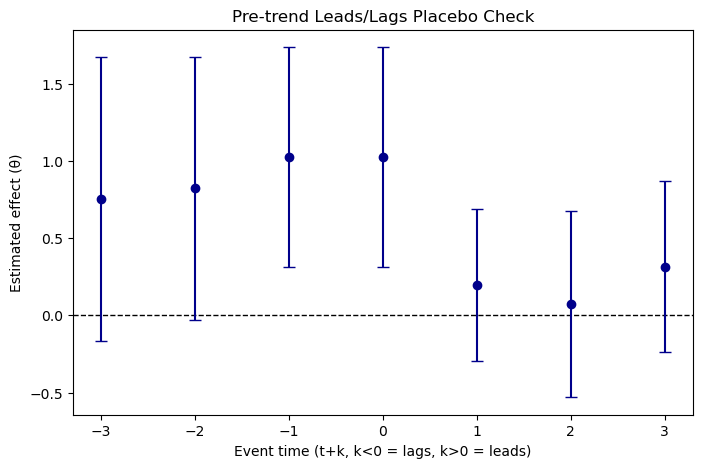

In [54]:
import matplotlib.pyplot as plt

# Define shifts: negative = lags, positive = leads
shifts = [-3, -2, -1, 0, 1, 2, 3]  
results = []

for k in shifts:
    # Create shifted treatment
    if k < 0:
        T = df.groupby('iso3c')['vulnerability'].shift(abs(k))  # lag
    elif k > 0:
        T = df.groupby('iso3c')['vulnerability'].shift(-k)      # lead
    else:
        T = df['vulnerability_lag1']  # your baseline lag-1 spec
    
    # Run DML
    res = run_dml_binary(T, df['high_spread'], X_base, df['year'], df['iso3c'])
    theta, se, p, effect_pp = res
    results.append((k, theta, se, p, effect_pp))

# Convert to DataFrame for plotting
df_res = pd.DataFrame(results, columns=['shift','theta','se','p','effect_pp'])

# Build confidence intervals
df_res['ci_low'] = df_res['theta'] - 1.96*df_res['se']
df_res['ci_high'] = df_res['theta'] + 1.96*df_res['se']

# Plot
plt.figure(figsize=(8,5))
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.errorbar(df_res['shift'], df_res['theta'], 
             yerr=1.96*df_res['se'], fmt='o', capsize=4, color='darkblue')

plt.xticks(shifts)
plt.xlabel("Event time (t+k, k<0 = lags, k>0 = leads)")
plt.ylabel("Estimated effect (θ)")
plt.title("Pre-trend Leads/Lags Placebo Check")
plt.show()

In [55]:
print(df_res)

   shift     theta        se         p  effect_pp    ci_low   ci_high
0     -3  0.756206  0.469083  0.106941   5.762040 -0.163196  1.675609
1     -2  0.822586  0.433502  0.057757   6.255798 -0.027078  1.672251
2     -1  1.024434  0.363731  0.004856   7.790854  0.311522  1.737345
3      0  1.024434  0.363731  0.004856   7.790854  0.311522  1.737345
4      1  0.194834  0.251139  0.437867   1.481995 -0.297399  0.687066
5      2  0.073013  0.307849  0.812524   0.555533 -0.530371  0.676396
6      3  0.316321  0.283976  0.265322   2.407534 -0.240272  0.872914


In [19]:
# ======================  DESCRIPTIVES FOR PAPER (LaTeX-READY)  ======================
# Python 3.9 compatible

from typing import Optional, List, Dict
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---------- CONFIG (edit if your names differ) ----------
CFG: Dict[str, object] = {
    "id_cols": ["iso3c", "year", "region"],
    "spread_col": "sovereign_spread",
    # Variables to include in VIF/correlation (fallback = all numeric minus IDs)
    "vif_corr_vars": None,   # e.g. ["vulnerability_lag1", "cpi_yoy", ...]
    # Summary stats: None = all numeric; or pass a curated ordered list
    "summary_vars": None
}

def _safe_numeric_df(df: pd.DataFrame, include: Optional[List[str]] = None) -> pd.DataFrame:
    """Return numeric dataframe, optionally restricted to 'include' list, minus obvious IDs."""
    if include is None:
        num = df.select_dtypes(include=[np.number]).copy()
        for c in CFG["id_cols"]:
            if c in num.columns:
                num = num.drop(columns=c)
        return num
    return df[include].select_dtypes(include=[np.number]).copy()

def _latex_table_wrapper(tabular_tex: str, caption: str, label: str,
                         longtable: bool = False, fit_to_width: bool = True) -> str:
    """
    Wrap a pandas LaTeX fragment to ensure it respects page margins.
    - longtable=True for very tall tables (we emit caption + tabular directly)
    - fit_to_width=True wraps in \resizebox{\linewidth}{!}{...}
    """
    # --- sanitize: drop any outer \begin{table}...\end{table} from pandas (older versions) ---
    lines = [ln for ln in tabular_tex.splitlines()
             if not ln.strip().startswith(r"\begin{table}")
             and not ln.strip().startswith(r"\end{table}")]
    tabular_tex = "\n".join(lines)

    if longtable:
        # Requires \usepackage{caption} in preamble for \captionof
        header = "\\setlength{\\tabcolsep}{6pt}\n\\renewcommand{\\arraystretch}{1.15}\n"
        header += f"\\captionof{{table}}{{{caption}}}\\label{{{label}}}\n"
        return header + tabular_tex + "\n"

    wrapped = "\\begin{table}[!htbp]\n\\centering\n"
    wrapped += "\\setlength{\\tabcolsep}{6pt}\n\\renewcommand{\\arraystretch}{1.15}\n"
    if fit_to_width:
        wrapped += "\\resizebox{\\linewidth}{!}{%\n"
    wrapped += tabular_tex + ("\n}" if fit_to_width else "") + "\n"
    wrapped += f"\\caption{{{caption}}}\n\\label{{{label}}}\n\\end{table}\n"
    return wrapped

def table_countries_per_region(df: pd.DataFrame, out_dir: Path) -> Path:
    t = (
        df.dropna(subset=["region", "iso3c"])
          .groupby("region")["iso3c"].nunique()
          .rename("Countries")
          .reset_index()
          .sort_values("Countries", ascending=False)
    )
    tex_body = t.to_latex(index=False, escape=True, na_rep="", float_format="%.0f")
    tex = _latex_table_wrapper(
        tex_body,
        caption="Number of Countries by Region",
        label="tab:countries_by_region",
        longtable=False,
        fit_to_width=True
    )
    p = out_dir / "tab_countries_by_region.tex"
    out_dir.mkdir(parents=True, exist_ok=True)
    p.write_text(tex)
    return p

def table_summary_stats(df: pd.DataFrame, out_dir: Path) -> Path:
    X = _safe_numeric_df(df, CFG["summary_vars"])
    desc = pd.DataFrame({
        "N": X.count(),
        "Mean": X.mean(),
        "Std. Dev.": X.std(ddof=1),
        "Min": X.min(),
        "P25": X.quantile(0.25),
        "Median": X.quantile(0.50),
        "P75": X.quantile(0.75),
        "Max": X.max(),
    }).reset_index().rename(columns={"index": "Variable"})
    if CFG["summary_vars"] is None:
        desc = desc.sort_values("Variable")
    tex_body = desc.to_latex(index=False, escape=True, na_rep="", float_format="%.3f")
    # Use "longtable-style" captioning via captionof to allow very tall tables to sit nicely
    tex = _latex_table_wrapper(
        tex_body,
        caption="Summary Statistics",
        label="tab:summary_stats",
        longtable=True,
        fit_to_width=False
    )
    p = out_dir / "tab_summary_statistics.tex"
    out_dir.mkdir(parents=True, exist_ok=True)
    p.write_text(tex)
    return p

def figure_hist_mean_spread_over_time(df: pd.DataFrame, out_dir: Path,
                                      start: int = 1995, end: int = 2024) -> Path:
    spread = str(CFG["spread_col"])
    ts = (df.loc[df["year"].between(start, end)]
            .groupby("year")[spread].mean()
            .dropna())
    plt.figure(figsize=(6, 4))
    plt.hist(ts.values, bins="auto")  # no explicit color/style
    plt.xlabel("Annual Mean Sovereign Spread")
    plt.ylabel("Frequency (Years)")
    plt.title(f"Histogram of Annual Mean Sovereign Spreads ({start}–{end})")
    out = out_dir / "fig_hist_mean_spread_over_time.pdf"
    out_dir.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(out, bbox_inches="tight")
    plt.close()
    ts.to_csv(out_dir / "annual_mean_spreads.csv", header=["annual_mean_spread"])
    return out

def table_correlations(df: pd.DataFrame, out_dir: Path) -> Path:
    X = _safe_numeric_df(df, CFG["vif_corr_vars"])
    if X.shape[1] < 2:
        raise ValueError("Not enough numeric variables for a correlation table.")
    corr = X.corr().round(3)
    tex_body = corr.to_latex(escape=True, index=True)
    tex = _latex_table_wrapper(
        tex_body,
        caption="Correlation Matrix of Key Variables",
        label="tab:correlations",
        longtable=False,
        fit_to_width=True
    )
    p = out_dir / "tab_correlations.tex"
    out_dir.mkdir(parents=True, exist_ok=True)
    p.write_text(tex)
    return p

def table_vif(df: pd.DataFrame, out_dir: Path) -> Path:
    X = _safe_numeric_df(df, CFG["vif_corr_vars"])
    # Drop zero-variance cols & rows with NA (VIF needs complete cases)
    X = X.loc[:, X.std(ddof=0) > 0]
    X = X.dropna(axis=0)
    if X.empty or X.shape[1] == 0:
        raise ValueError("No usable columns for VIF after cleaning.")
    X_const = sm.add_constant(X, has_constant="add")
    vifs = []
    cols = list(X_const.columns)  # includes "const"
    for i in range(len(cols)):
        try:
            vif_i = variance_inflation_factor(X_const.values, i)
        except Exception:
            vif_i = np.nan
        vifs.append({"Variable": cols[i], "VIF": vif_i})
    vif_df = pd.DataFrame(vifs)
    vif_df = vif_df[vif_df["Variable"] != "const"].copy()
    vif_df["VIF"] = vif_df["VIF"].round(2)
    vif_df = vif_df.sort_values("VIF", ascending=False).reset_index(drop=True)
    tex_body = vif_df.to_latex(index=False, escape=True)
    tex = _latex_table_wrapper(
        tex_body,
        caption="Variance Inflation Factors (Multicollinearity Diagnostic)",
        label="tab:vif",
        longtable=False,
        fit_to_width=True
    )
    p = out_dir / "tab_vif.tex"
    out_dir.mkdir(parents=True, exist_ok=True)
    p.write_text(tex)
    return p

def build_all_descriptives(df: pd.DataFrame, out_dir: Path) -> Dict[str, Path]:
    out_dir.mkdir(parents=True, exist_ok=True)
    paths: Dict[str, Path] = {}
    paths["countries_by_region_tex"] = table_countries_per_region(df, out_dir)
    paths["summary_stats_tex"]       = table_summary_stats(df, out_dir)
    paths["correlations_tex"]        = table_correlations(df, out_dir)
    paths["vif_tex"]                 = table_vif(df, out_dir)
    paths["hist_mean_spread_pdf"]    = figure_hist_mean_spread_over_time(df, out_dir, start=1995, end=2024)
    return paths
# ======================  END (PY 3.9 COMPATIBLE + WRAPPER PATCH)  ======================